# Truncated Gaussian Process

Messing around, for now.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import george
from george import kernels

%matplotlib inline

In [2]:
np.random.seed(1234)
x = 10 * np.sort(np.random.rand(30))
yerr = 0.3 * np.ones_like(x)

def func(x):
    #return np.maximum(np.zeros_like(x), np.sin(x)/0.3)
    return np.sin(x)/1.


y = func(x) + yerr * np.random.randn(len(x))

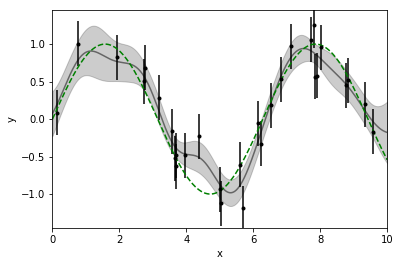

In [3]:
kernel = np.var(y) * kernels.ExpSquaredKernel(0.5)
gp = george.GP(kernel)
gp.compute(x, yerr)

x_pred = np.linspace(0, 10, 500)
pred, pred_var = gp.predict(y, x_pred, return_var=True)
pred_std = np.sqrt(pred_var)

plt.fill_between(x_pred, pred - pred_std, pred + pred_std,
                color="k", alpha=0.2)
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x_pred, func(x_pred), "--g")
plt.xlim(0, 10)
plt.ylim(-1.45, 1.45)
plt.xlabel("x")
plt.ylabel("y");

In [4]:
#Let's define a truncated GP that cannot produce curves below -0.5
def _calc_Z(y, s, a, b):
    al = (a - y)/s
    be = (b - y)/s
    return ss.norm.cdf(be) - ss.norm.cdf(al)

def extra_mean(y, s, a, b):
    al = (a - y)/s
    be = (b - y)/s
    Z = _calc_Z(y, s, a, b)
    return s * (ss.norm.pdf(al) - ss.norm.pdf(be))/Z

def extra_var(y, s, a, b):
    al = (a - y)/s
    be = (b - y)/s
    Z = _calc_Z(y, s, a, b)
    phi_al = ss.norm.pdf(al)
    phi_be = ss.norm.pdf(be)
    return s**2 * ((al*phi_al - be*phi_be)/Z - 
                   (phi_al - phi_be)**2/Z)

In [10]:
#a = 0
b = 10
#pred_var2 = pred_var + extra_var(pred, pred_std, a, b)
#pred_std2 = np.sqrt(pred_var2)
#The interesting quantity is the 16 and 84 percentile curves
pred2 = np.zeros_like(pred)
low = np.zeros_like(pred2)
hi = np.zeros_like(pred2)
def afunc(x):
    return 0.05*x
for i in range(len(pred2)):
    pred2[i] = pred[i] + extra_mean(pred[i], pred_std[i], afunc(x_pred[i]) ,b)

    a_, b_ = (afunc(x_pred[i]) - pred[i]) / pred_std[i], (b - pred[i]) / pred_std[i]
    low[i] = ss.truncnorm.ppf(0.16, a=a_, b=b_, 
                              loc=pred[i], scale=pred_std[i])
    hi[i] = ss.truncnorm.ppf(0.84, a=a_, b=b_, 
                             loc=pred[i], scale=pred_std[i])

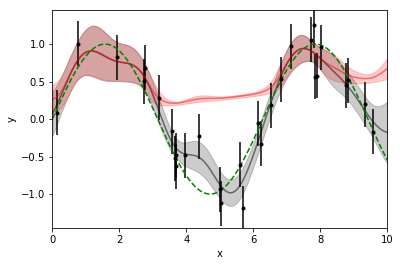

In [11]:
plt.fill_between(x_pred, pred - pred_std, pred + pred_std,
                color="k", alpha=0.2)
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)

plt.fill_between(x_pred, low, hi,
                color="red", alpha=0.2)
plt.plot(x_pred, pred2, "red", lw=1.5, alpha=0.5)

#print(pred - pred2)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x_pred, func(x_pred), "--g")
plt.xlim(0, 10)
plt.ylim(-1.45, 1.45)
plt.xlabel("x")
plt.ylabel("y");
plt.savefig("example.png", dpi=300)

In [ ]:
#Let's make draws
#for _ in range(100):
y_sample = gp.sample_conditional(y, x_pred)
y_draw = np.zeros_like(x_pred)
for i in range(len(x_pred)):
    
    a_, b_ = (afunc(x_pred[i]) - pred[i]) / pred_std[i], (b - pred[i]) / pred_std[i]
    
    percent = ss.norm.cdf(y_sample[i], loc=pred[i], scale=pred_std[i])
    y_draw[i] = ss.truncnorm.ppf(percent, a=a_, b=b_, 
                                 loc=pred[i], scale=pred_std[i])
plt.plot(x_pred, y_sample, "gray", lw=1.5, alpha=0.5)
plt.plot(x_pred, y_draw, "purple", lw=1.5, alpha=0.5)

In [ ]:
plt.fill_between(x_pred, pred - pred_std, pred + pred_std,
                color="k", alpha=0.2)
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
plt.plot(x_pred, y_sample, "gray", lw=1.5, alpha=0.5)


#plt.fill_between(x_pred, pred2 - pred_std2, pred2 + pred_std2,
#                color="cyan", alpha=0.2)
plt.plot(x_pred, pred2, "red", lw=1.5, alpha=0.5)
plt.plot(x_pred, y_draw, "purple", lw=1.5, alpha=0.5)

#print(pred - pred2)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x_pred, func(x_pred), "--g")
plt.xlim(0, 10)
plt.ylim(-1.45, 1.45)
plt.xlabel("x")
plt.ylabel("y");

In [ ]:
plt.fill_between(x_pred, pred - pred_std, pred + pred_std,
                color="k", alpha=0.2)
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)


#plt.fill_between(x_pred, pred2 - pred_std2, pred2 + pred_std2,
#                color="cyan", alpha=0.2)
plt.plot(x_pred, pred2, "red", lw=1.5, alpha=0.5)

#print(pred - pred2)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x_pred, func(x_pred), "--g")
plt.xlim(0, 10)
plt.ylim(-1.45, 1.45)
plt.xlabel("x")
plt.ylabel("y");

for _ in range(100):
    y_sample = gp.sample_conditional(y, x_pred)
    y_draw = np.zeros_like(x_pred)
    for i in range(len(x_pred)):
    
        a_, b_ = (afunc(x_pred[i]) - pred[i]) / pred_std[i], (b - pred[i]) / pred_std[i]
    
        percent = ss.norm.cdf(y_sample[i], loc=pred[i], scale=pred_std[i])
        y_draw[i] = ss.truncnorm.ppf(percent, a=a_, b=b_, 
                                     loc=pred[i], scale=pred_std[i])
    #plt.plot(x_pred, y_sample, "gray", lw=1.5, alpha=0.5)
    plt.plot(x_pred, y_draw, "purple", lw=1.5, alpha=0.2)